The objective of this notebook is to do an basic exploratory analysis of the dataset and check its characteristics

## Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("../data/bronze/spam.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df.describe()


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Change data types

In [5]:
df['Category'] = df['Category'].map({"ham": 0, "spam": 1}).astype(int)
df['Message'] = df['Message'].astype(str)

## Duplicated rows analysis

In [6]:
total_duplicates = df.duplicated().sum()
percent_duplicates = (total_duplicates / len(df)) * 100

print(f"Total duplicated rows: {total_duplicates}")
print(f"Percentage of duplicated: {percent_duplicates:.2f}%")


Total duplicated rows: 415
Percentage of duplicated: 7.45%


In [7]:
duplicates_summary = df[df.duplicated(keep=False)].groupby(df.columns.tolist()).size().reset_index(name='count')
duplicates_summary

,Category,Message,count
0,0,1) Go to write msg 2) Put on Dictionary mode 3...,3
1,0,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2,0,A Boy loved a gal. He propsd bt she didnt mind...,2
3,0,"A bit of Ur smile is my hppnss, a drop of Ur t...",2
4,0,"A boy was late 2 home. His father: ""POWER OF F...",2
...,...,...,...
284,1,You have an important customer service announc...,2
285,1,You have won a Nokia 7250i. This is what you g...,3
286,1,You won't believe it but it's true. It's Incre...,2
287,1,You've won tkts to the EURO2004 CUP FINAL or £...,2


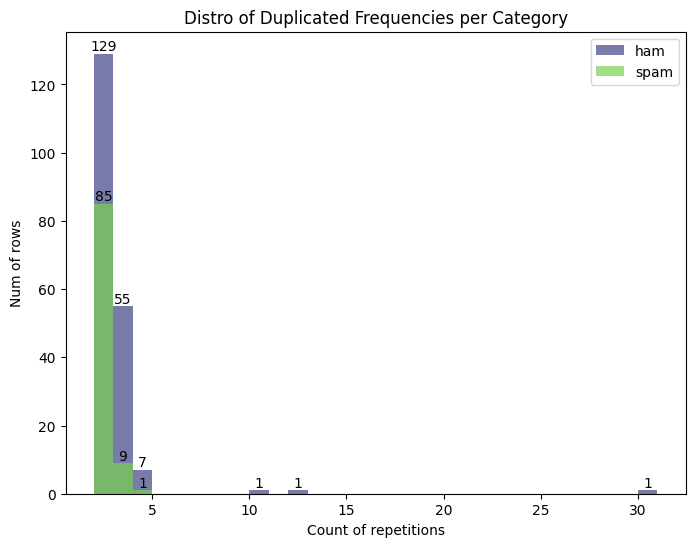

In [8]:
category_0 = duplicates_summary[duplicates_summary['Category'] == 0]
category_1 = duplicates_summary[duplicates_summary['Category'] == 1]

bins = range(min(duplicates_summary['count']), max(duplicates_summary['count']) + 2, 1)

cmap = plt.cm.viridis
color_0 = cmap(0.2) 
color_1 = cmap(0.8)  

plt.figure(figsize=(8, 6))
n_0, bins_0, patches_0 = plt.hist(category_0['count'], bins=bins, color=color_0, alpha=0.7, label='ham')
n_1, bins_1, patches_1 = plt.hist(category_1['count'], bins=bins, color=color_1, alpha=0.7, label='spam')

for i in range(len(patches_0)):
    height = patches_0[i].get_height()  
    if height > 0: 
        plt.text(patches_0[i].get_x() + patches_0[i].get_width() / 2, height, str(int(height)),
                 ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(patches_1)):
    height = patches_1[i].get_height()  
    if height > 0:  
        plt.text(patches_1[i].get_x() + patches_1[i].get_width() / 2, height, str(int(height)),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("Distro of Duplicated Frequencies per Category")
plt.xlabel("Count of repetitions")
plt.ylabel("Num of rows")
plt.legend()
plt.show()


Note:

It seems that duplicated e-mails are less likely to be repeated. I didn't expect that

In [9]:
duplicates_with_diff_category = (
    df.groupby(df.columns.difference(['Category']).tolist())
    .agg({'Category': 'nunique'})
    .reset_index()
)
conflicting_rows = duplicates_with_diff_category[duplicates_with_diff_category['Category'] > 1]

conflicting_rows



,Message,Category


In [10]:
conflicting_indices = df[df.duplicated(subset=df.columns.difference(['Category']), keep=False)]
conflicting_indices.sort_values(by=df.columns.difference(['Category']).tolist())


,Category,Message
2124,1,#ERROR!
717,1,#ERROR!
505,1,#ERROR!
2163,0,1) Go to write msg 2) Put on Dictionary mode 3...
1373,0,1) Go to write msg 2) Put on Dictionary mode 3...
...,...,...
1381,0,i dnt wnt to tlk wid u
4004,0,somewhere out there beneath the pale moon ligh...
1412,0,somewhere out there beneath the pale moon ligh...
2389,0,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...


In [11]:
df.drop_duplicates(inplace=True)

## Distribution of unique HAM VS. SPAM messages

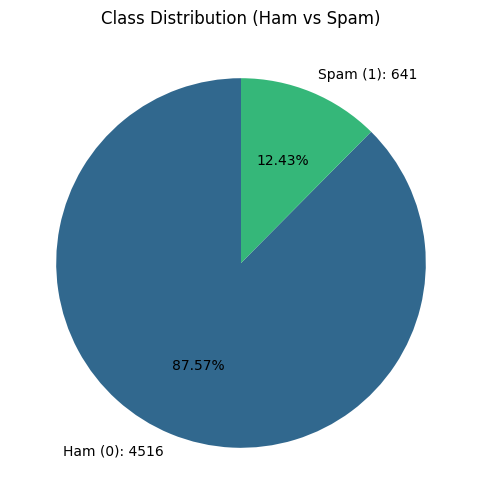

In [12]:
category_counts = df['Category'].value_counts()
category_labels = ["Ham (0)", "Spam (1)"]

viridis_colors = sns.color_palette("viridis", len(category_counts))

plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=[f"{label}: {count}" for label, count in zip(category_labels, category_counts)], 
    autopct=lambda p: f"{p:.2f}%",  
    colors=viridis_colors,  
    startangle=90,  
)
plt.title("Class Distribution (Ham vs Spam)")
plt.show()


Observations:

- The dataset is very imbalanced with the target class only containing a 13,41% of the class "SPAM" 

## Word count distribution

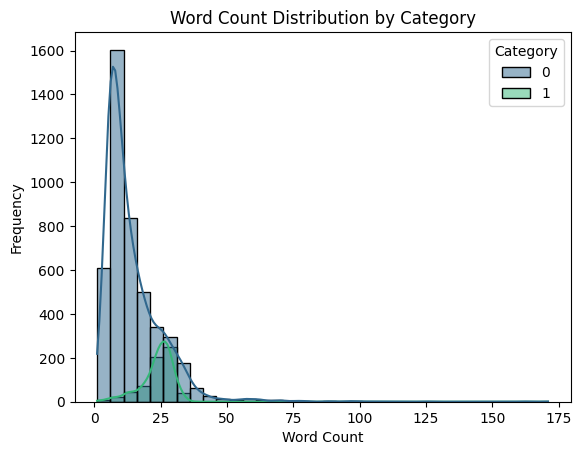

In [13]:
df['word_count'] = df['Message'].apply(lambda x: len(x.split()))
bins = np.arange(df['word_count'].min(), df['word_count'].max() + 5, 5)
sns.histplot(data=df, x='word_count', hue='Category', bins=bins, kde=True, palette="viridis")
plt.title("Word Count Distribution by Category")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


## High word count distribution

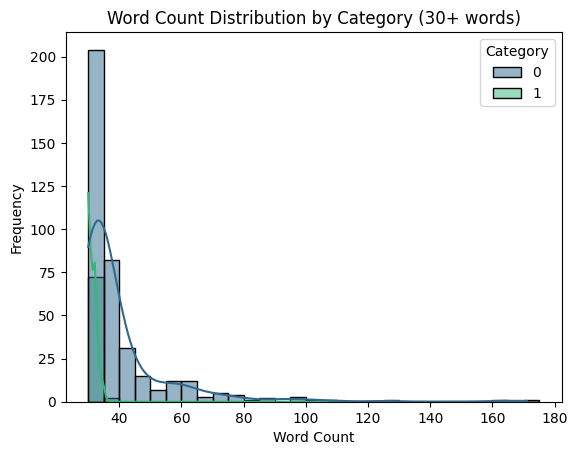

In [14]:
df_filtered = df[df['word_count'] >= 30]

bins = np.arange(df_filtered['word_count'].min(), df_filtered['word_count'].max() + 5, 5)
sns.histplot(data=df_filtered, x='word_count', hue='Category', bins=bins, kde=True, palette="viridis")
plt.title("Word Count Distribution by Category (30+ words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [15]:
spam_emails = df[df['Category'] == 1]

max_words_idx = spam_emails['word_count'].idxmax()
max_words_email = spam_emails.loc[max_words_idx, 'Message']

print(f"This is the SPAM e-mail with highest number of words ({spam_emails.loc[max_words_idx, 'word_count']} words):\n")
print(max_words_email)

This is the SPAM e-mail with highest number of words (35 words):

Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+


Observations: 

- Most HAM messages have between 0 and 25 words. The frequency falls dramatically when the word count increases. 
- Most SPAM messages are also short but they are more likely to have between 10 and 40 words. 
- There is a high superposition in the range of 20-35 words that could affect the classification.
- There are no long SPAM messages (> 35 words)
- HAM messages have higher variability than the SPAM messages (as per word count)



## Char count distribution

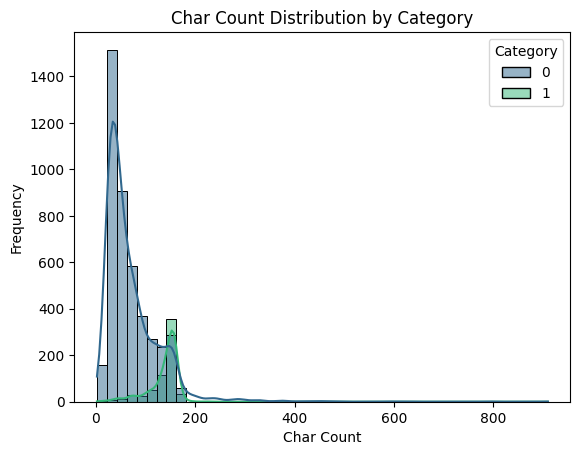

In [16]:
df['char_count'] = df['Message'].apply(len)
bins = np.arange(df['char_count'].min(), df['word_count'].max() + 20, 20)
sns.histplot(data=df, x='char_count', hue='Category', bins=bins, kde=True, palette="viridis")
plt.title("Char Count Distribution by Category")
plt.xlabel("Char Count")
plt.ylabel("Frequency")
plt.show()

## High char count distribution

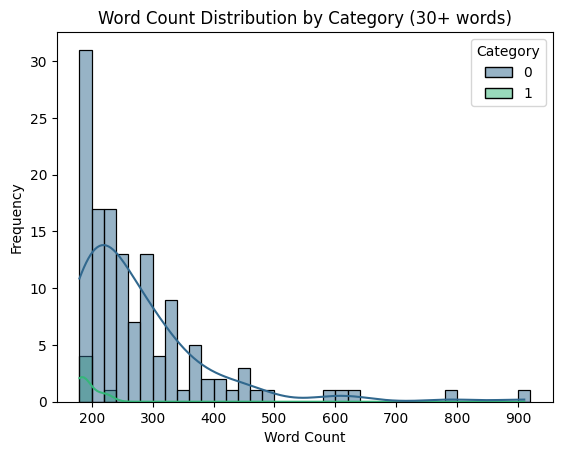

In [17]:
df_filtered = df[df['char_count'] >= 180]

bins = np.arange(df_filtered['char_count'].min(), df_filtered['char_count'].max() + 20, 20)
sns.histplot(data=df_filtered, x='char_count', hue='Category', bins=bins, kde=True, palette="viridis")
plt.title("Word Count Distribution by Category (30+ words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

Observations:

- The distribution of HAM messages per char count shows that there are a lot os messages with very few characters ( <100 chars)
- The distribution of SPAM messages per char count shows that there are a lot of messages with more characters ( >100 chars)
- The SPAM distribution goes dramatically down after 150 chars
- There are no more SPAM messages when the count is higher than 223 chars
- HAM messages have more variability in number of chars than SPAM messages 

## Most common words in each class

For that I clean the text, tokenize and apply stopwords

In [18]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
from string import punctuation

def clean_text(text):
    special_replacements = {
        r"£": "pound",
        r"\$": "dollar",
        r"\€": "euro",
        r"%": "percentage", 
        r"ì": "i",
        r"ü": "you",
        }
    
    emoticon_pattern = re.compile(r"""
    [:;=Xx]           
    [-~]?             
    [\)\]\(\[dDpP/]   
    """, re.VERBOSE)
    
    for pattern, replacement in special_replacements.items():
        text = re.sub(pattern, replacement, text)
    text = re.sub(emoticon_pattern, 'emoji', text)
    text = text.lower()
    text = re.sub('<[^<>]+>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub('[0-9]+', 'number', text)
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    text = text.translate(str.maketrans('', '', punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_cleaned = df.copy()
df_cleaned['Message']=df_cleaned['Message'].apply(clean_text)
df_cleaned['message_tokenized'] = df_cleaned['Message'].apply(word_tokenize)

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)


df_cleaned['message_clean'] = df_cleaned['message_tokenized'].apply(remove_stopwords)
df_cleaned

,Category,Message,word_count,char_count,message_tokenized,message_clean
0,0,go until jurong point crazy available only in ...,20,111,"[go, until, jurong, point, crazy, available, o...",go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni,6,29,"[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,1,free entry in number a wkly comp to win fa cup...,28,155,"[free, entry, in, number, a, wkly, comp, to, w...",free entry number wkly comp win fa cup final t...
3,0,u dun say so early hor u c already then say,11,49,"[u, dun, say, so, early, hor, u, c, already, t...",u dun say early hor u c already say
4,0,nah i dont think he goes to usf he lives aroun...,13,61,"[nah, i, dont, think, he, goes, to, usf, he, l...",nah dont think goes usf lives around though
...,...,...,...,...,...,...
5567,1,this is the numbernd time we have tried number...,30,160,"[this, is, the, numbernd, time, we, have, trie...",numbernd time tried number contact u u poundnu...
5568,0,will you b going to esplanade fr home,8,36,"[will, you, b, going, to, esplanade, fr, home]",b going esplanade fr home
5569,0,pity was in mood for that soany other suggestions,10,57,"[pity, was, in, mood, for, that, soany, other,...",pity mood soany suggestions
5570,0,the guy did some bitching but i acted like id ...,26,125,"[the, guy, did, some, bitching, but, i, acted,...",guy bitching acted like id interested buying s...


In [19]:
word = "I'm"

if word in stop_words:
    print(f"'{word}' is a stopword.")
else:
    print(f"'{word}' is not a stopword.")


'I'm' is not a stopword.


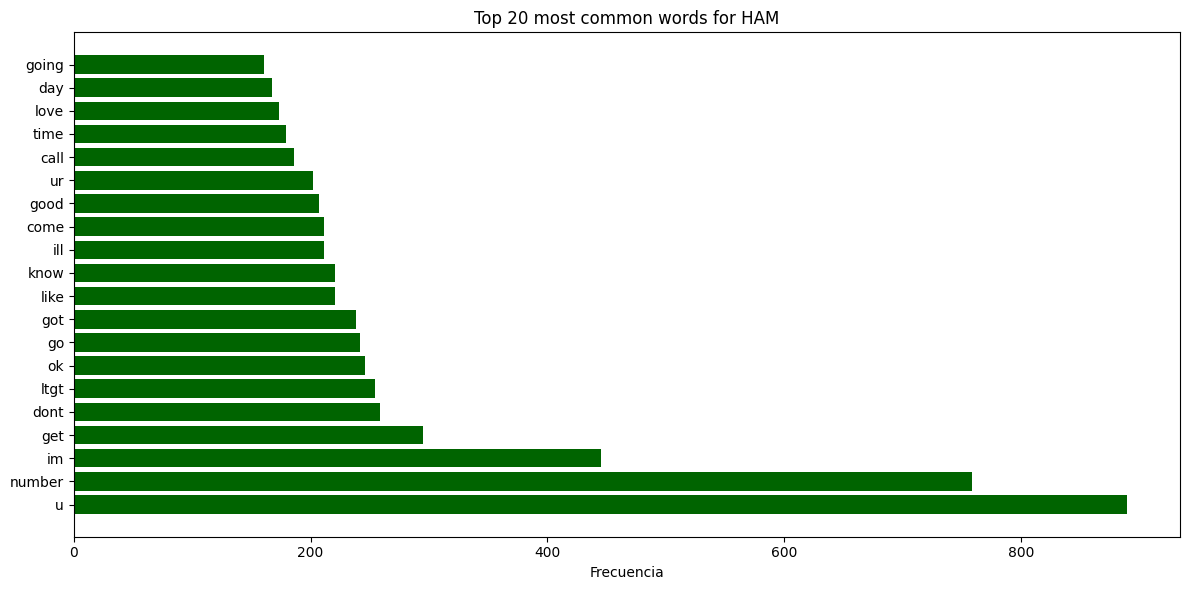

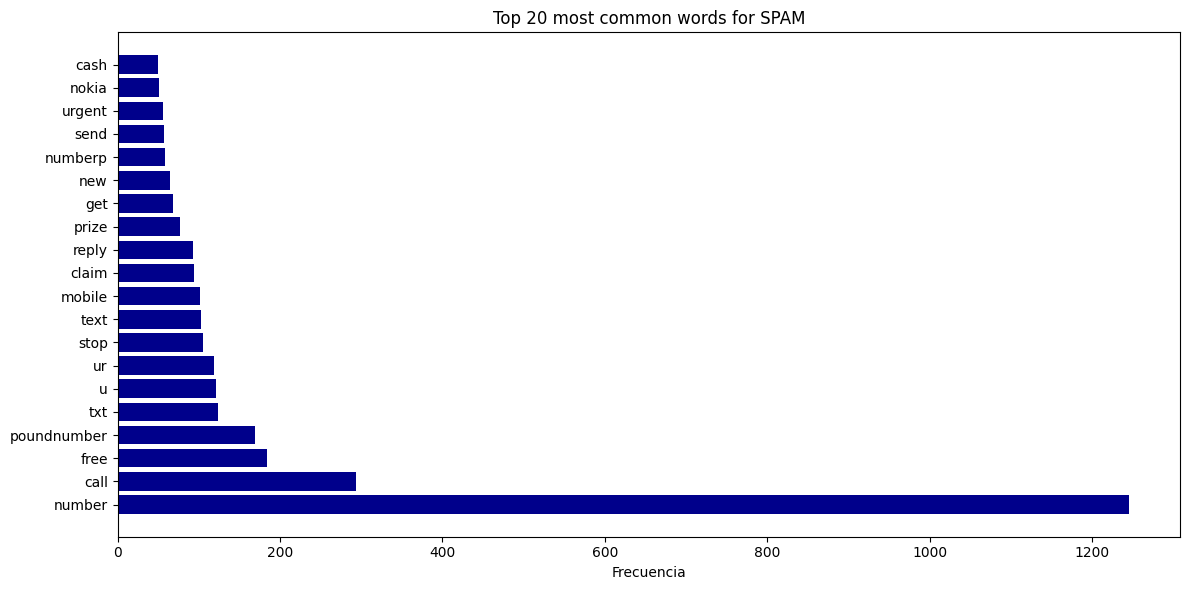

In [20]:
from collections import Counter

ham_data = df_cleaned[df_cleaned['Category'] == 0]
spam_data = df_cleaned[df_cleaned['Category'] == 1]

ham_words = Counter(" ".join(ham_data["message_clean"]).split()).most_common(20)
spam_words = Counter(" ".join(spam_data["message_clean"]).split()).most_common(20)

ham_words_list, ham_counts = zip(*ham_words)
spam_words_list, spam_counts = zip(*spam_words)

plt.figure(figsize=(12, 6))
plt.barh(ham_words_list, ham_counts, color="darkgreen")
plt.xlabel('Frecuencia')
plt.title('Top 20 most common words for HAM')
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.barh(spam_words_list, spam_counts, color="darkblue")
plt.xlabel('Frecuencia')
plt.title('Top 20 most common words for SPAM')
plt.tight_layout()

plt.show()


Notes:
Most common words in each class are different. That will help the model to differentiate between types of e-mails.

There is a lot of misspelling in both HAM and SPAM e-mails (u, ur, ill, etc), grammatical errors (poundnumber, numberp) and abbreviations (txt, ltgt? what does that even mean?) 


For the curious ones what Google says about "ltgt":
1. Long-Term Genistein Treatment in Biochemistry contexts.
2. Long-Term Growth in economy or investing
3. Less Than Greater Than in coding or math


In [21]:
# pd.set_option('max_colwidth', None)

ltgt_means = df_cleaned[df_cleaned['message_tokenized'].apply(lambda x: 'ltgt' in x)]
ltgt_means['Message']

44      great i hope you like your man well endowed i ...
51      a gram usually runs like ltgt a half eighth is...
78                    does not operate after ltgt or what
178     turns out my friends are staying for the whole...
200                        found it enc ltgt where you at
                              ...                        
5478                          no probably ltgt percentage
5504                       wait i will msg after ltgt min
5513    yes please leave at ltgt so that at ltgt we ca...
5557    no i meant the calculation is the same that lt...
5559    if you arent here in the next ltgt hours imma ...
Name: Message, Length: 197, dtype: object

Notes: 

Ok, some of these messages are perturbing. Are there some that belong to SPAM?

In [22]:
ltgt_means['Category'].value_counts()


Category
0    197
Name: count, dtype: int64